In [1]:
import json
import os
import random
from datetime import datetime, timedelta

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

pd.options.mode.chained_assignment = None

# load data

In [2]:
x_train = pd.read_parquet("../data/selected_features/x_train/data.parquet")
x_cv = pd.read_parquet("../data/selected_features/x_cv/data.parquet")
x_test = pd.read_parquet("../data/selected_features/x_test/data.parquet")

y_train = pd.read_parquet("../data/selected_features/y_train/data.parquet")["Churn"]
y_cv = pd.read_parquet("../data/selected_features/y_cv/data.parquet")["Churn"]
y_test = pd.read_parquet("../data/selected_features/y_test/data.parquet")["Churn"]

x_train = pd.concat([x_train, x_cv])
y_train = pd.concat([y_train, y_cv])

# Evaluation setup

<img src="https://www.mdpi.com/technologies/technologies-09-00081/article_deploy/html/images/technologies-09-00081-g001.png" width="800" height="400">

1. We need to boost values of diagonal elements in the confusion matrix
1. In order to monitor the performance of our models we can create Precision Recall Matrices
1. Where in we divide Confusion matrix by
    - sum of confusion matrix across rows -> to get Precision matrix
    - sum of confusion matrix across columns -> to get Recall matrix

# Precision recall matrix

In [3]:
np.seterr(divide="ignore", invalid="ignore")


def get_pr_matrix(y_true, y_pred):
    """
    Get precision recall matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    # avoid nans in matrix, replace with 0
    pr_matrix = cm / cm.sum(axis=0)
    pr_matrix = np.nan_to_num(pr_matrix)
    re_matrix = (cm.T / cm.sum(axis=1)).T
    re_matrix = np.nan_to_num(re_matrix)

    return pr_matrix, re_matrix


def plot_matrix_heatmap(mat, labels=[0, 1], title="None"):
    plt.figure(figsize=(3, 2), dpi=140)
    plt.title(title)
    cmap = sns.light_palette("green")
    sns.heatmap(
        mat, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels,
    )
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.show()


def plot_pr_matrix_heatmaps(y_true, y_pred):
    p, r = get_pr_matrix(y_true, y_pred)

    plot_matrix_heatmap(p, title="Precision Matrix")
    plot_matrix_heatmap(r, title="Recall Matrix")

# Random model

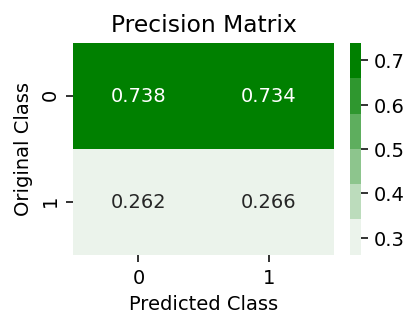

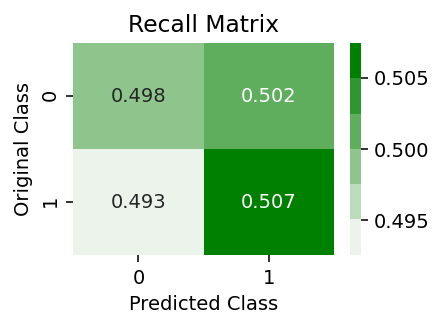

log loss of random model on train set : 1.0011490190201244


In [4]:
random_pred = np.random.randint(low=0, high=2, size=x_train.shape[0])
random_pred_proba = np.random.random(size=x_train.shape[0])


plot_pr_matrix_heatmaps(y_train, random_pred)

ll_random_train = log_loss(y_train, random_pred_proba)
print(f"log loss of random model on train set : {ll_random_train}")

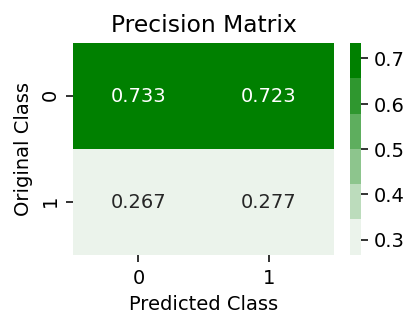

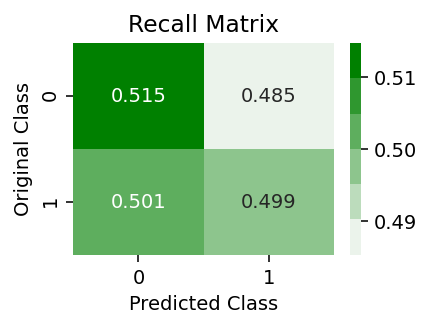

log loss of random model on test set : 1.0281380171876098


In [5]:
random_pred = np.random.randint(low=0, high=2, size=x_test.shape[0])
random_pred_proba = np.random.random(size=x_test.shape[0])


plot_pr_matrix_heatmaps(y_test, random_pred)

ll_random_train = log_loss(y_test, random_pred_proba)
print(f"log loss of random model on test set : {ll_random_train}")

# Class weights

Handle imbalance in labels

In [6]:
def get_class_weights(y, classes=[0, 1]):
    """
    for "balanced" 
    w = n_samples / (n_classes * np.bincount(y))
    """

    w = compute_class_weight("balanced", classes=classes, y=y,)
    class_weights = {i: j for i, j in zip(classes, w)}

    return class_weights


# demo
get_class_weights(y_train, classes=[0, 1])

{0: 0.679122468659595, 1: 1.895693135935397}

# Time series split

In [7]:
x_train.columns

Index(['TotalCharges', 'MonthlyCharges', 'Contract_0', 'sin_day', 'cos_day',
       'TechSupport_0'],
      dtype='object')

In [8]:
tscv = TimeSeriesSplit(n_splits=10)
tscv

TimeSeriesSplit(max_train_size=None, n_splits=10)

# Training XgBoost model

tune num_estimators first

## tuning num_estimators

In [39]:
num_estimators_list = [5, 7, 10, 15, 20, 30, 40, 50, 60, 70, 100, 150]

tscv_loss_dict = {}
for ix, ne in enumerate(num_estimators_list):
    print(f"num_estimators {ne}")

    tscv_loss_list = []

    for train_index, cv_index in tscv.split(x_train):

        # get data for cv ready
        x_train_req = x_train.iloc[train_index]
        x_cv_req = x_train.iloc[cv_index]

        y_train_req = y_train.iloc[train_index]
        y_cv_req = y_train.iloc[cv_index]

        counts, uniques = np.unique(y_train_req, return_counts=True)
        scale_pos_weight = counts[0] / (counts[1] + 1)

        # get class weights
        class_weights = get_class_weights(y_train[train_index], classes=[0, 1])

        # print(f"len_train {len(train_index)}, len_cv {len(cv_index)}")
        clf = xgb.XGBClassifier(
            objective="binary:logistic",
            n_estimators=ne,
            # scale_pos_weight=scale_pos_weight,
            eval_metric="logloss",
            booster="gbtree",
        )
        clf.fit(x_train_req, y_train_req)

        # get log los train
        y_pred_train_ll = clf.predict_proba(x_train_req)
        ll_train = log_loss(y_train_req, y_pred_train_ll)

        # get log los cv set
        y_pred_val_ll = clf.predict_proba(x_cv_req)
        ll_cv = log_loss(y_cv_req, y_pred_val_ll)

        tscv_loss_list.append({"ll_train": ll_train, "ll_cv": ll_cv})

    tscv_loss_dict[ix] = tscv_loss_list

num_estimators 5
num_estimators 7
num_estimators 10
num_estimators 15
num_estimators 20
num_estimators 30
num_estimators 40
num_estimators 50
num_estimators 60
num_estimators 70
num_estimators 100
num_estimators 150


In [40]:
df_tscv = pd.DataFrame(tscv_loss_dict.items()).rename(
    columns={0: "iteration", 1: "losses"}
)

df_tscv["ll_train"] = df_tscv["losses"].apply(
    lambda x: np.mean([i["ll_train"] for i in x])
)
df_tscv["ll_cv"] = df_tscv["losses"].apply(lambda x: np.mean([i["ll_cv"] for i in x]))


df_tscv["num_estimators"] = num_estimators_list
df_tscv = df_tscv.drop(columns=["losses"])
df_tscv

,iteration,ll_train,ll_cv,num_estimators
0,0,0.388165,0.454162,5
1,1,0.356241,0.443762,7
2,2,0.327449,0.441487,10
3,3,0.298512,0.446517,15
4,4,0.282199,0.452993,20
5,5,0.252532,0.465271,30
6,6,0.227737,0.476172,40
7,7,0.208868,0.487248,50
8,8,0.191522,0.499652,60
9,9,0.178709,0.509084,70


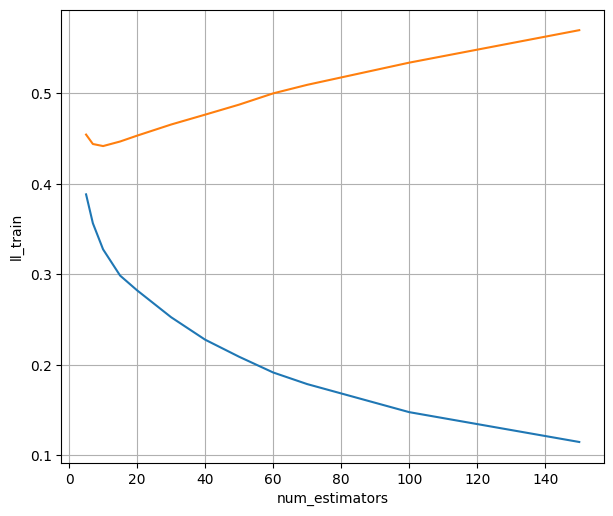

In [41]:
plt.figure(figsize=[7, 6], dpi=100)
sns.lineplot(y="ll_train", x="num_estimators", data=df_tscv)
sns.lineplot(y="ll_cv", x="num_estimators", data=df_tscv)
plt.grid()

Using `n_estimators = 15` as best param

## re-train with best num_estimators

In [42]:
x_train = pd.read_parquet("../data/selected_features/x_train/data.parquet")
x_cv = pd.read_parquet("../data/selected_features/x_cv/data.parquet")
x_test = pd.read_parquet("../data/selected_features/x_test/data.parquet")

y_train = pd.read_parquet("../data/selected_features/y_train/data.parquet")["Churn"]
y_cv = pd.read_parquet("../data/selected_features/y_cv/data.parquet")["Churn"]
y_test = pd.read_parquet("../data/selected_features/y_test/data.parquet")["Churn"]

x_train = pd.concat([x_train, x_cv])
y_train = pd.concat([y_train, y_cv])

In [45]:
clf = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=15,
    eval_metric="logloss",
    booster="gbtree",
)
clf.fit(x_train, y_train)

y_pred_train = clf.predict(x_train)
y_pred_test = clf.predict(x_test)

y_pred_proba_train = clf.predict_proba(x_train)
y_pred_proba_test = clf.predict_proba(x_test)

## Check log loss

In [46]:
log_loss_train = log_loss(y_train, y_pred_proba_train)
log_loss_test = log_loss(y_test, y_pred_proba_test)

print(f"log loss train {log_loss_train}")
print(f"log loss test {log_loss_test}")

log loss train 0.3509486212673173
log loss test 0.44877092160860893


## Check PR matrix

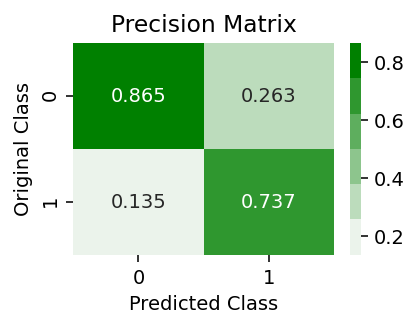

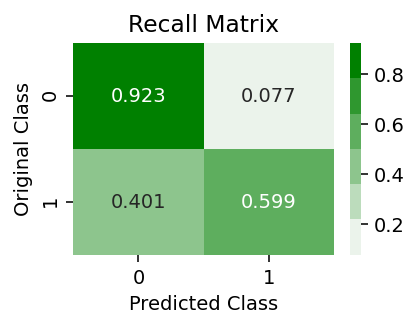

In [47]:
plot_pr_matrix_heatmaps(y_train, y_pred_train)

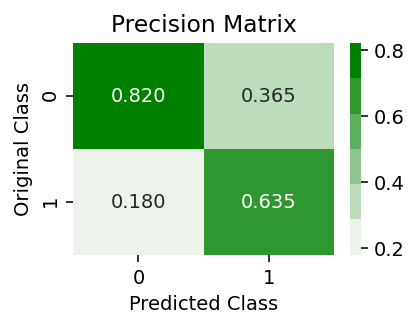

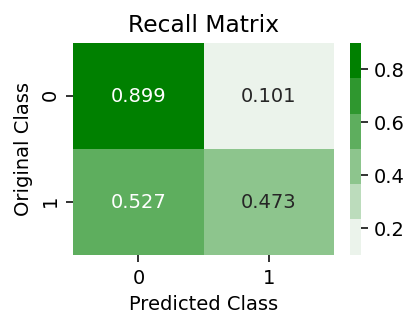

In [48]:
plot_pr_matrix_heatmaps(y_test, y_pred_test)

# Fine tuning Random Forest Model

In [63]:
np.random.uniform(low=0, high=0.5, size=4)

array([0.28698826, 0.29934775, 0.492489  , 0.26996667])

In [100]:
%%time

# using best n_estimators got from training


clf = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=15,
    eval_metric="logloss",
    booster="gbtree",
)


param_grid = {
    "colsample_bytree": [0.2, 0.5, 0.9, 1],
    "learning_rate": [0.01, 0.1, 0.25, 0.3],
    "max_depth": [2, 3, 4],
    "reg_alpha": [1e-3, 1e-2, 0.1, 1],
    "reg_lambda": [1e-3, 1e-2, 0.1, 1]
    # "subsample": [0.2, 0.5, 0.8, 0.9, 1],
}


grid_search_clf = GridSearchCV(
    estimator=clf, param_grid=param_grid, cv=None, refit=True, scoring="neg_log_loss"
)
grid_search_clf.fit(x_train, y_train)

CPU times: user 16min 34s, sys: 20.7 s, total: 16min 54s
Wall time: 1min 27s


GridSearchCV(estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     ma...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=15, n_jobs=None,
  

In [101]:
grid_search_clf.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.25,
 'max_depth': 3,
 'reg_alpha': 1,
 'reg_lambda': 0.001}

In [102]:
y_pred_train = grid_search_clf.predict(x_train)
y_pred_test = grid_search_clf.predict(x_test)

y_pred_proba_train = grid_search_clf.predict_proba(x_train)
y_pred_proba_test = grid_search_clf.predict_proba(x_test)

## Check log loss

In [103]:
log_loss_train = log_loss(y_train, y_pred_proba_train)
log_loss_test = log_loss(y_test, y_pred_proba_test)

print(f"log loss train {log_loss_train}")
print(f"log loss test {log_loss_test}")

log loss train 0.4080161904039395
log loss test 0.44461666364711894


## Check PR matrix

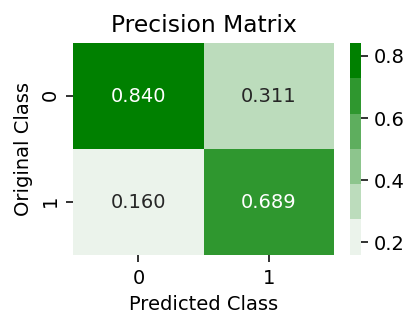

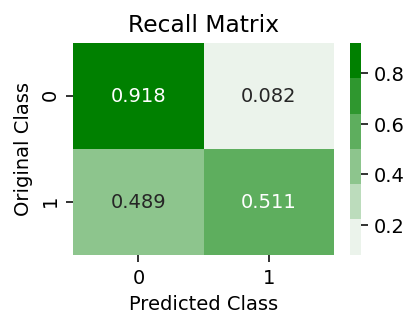

In [104]:
plot_pr_matrix_heatmaps(y_train, y_pred_train)

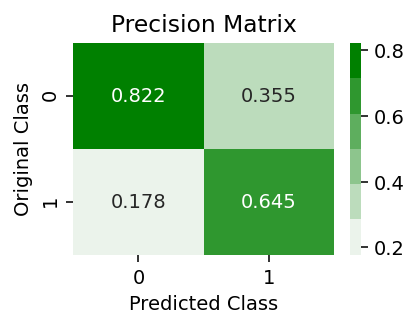

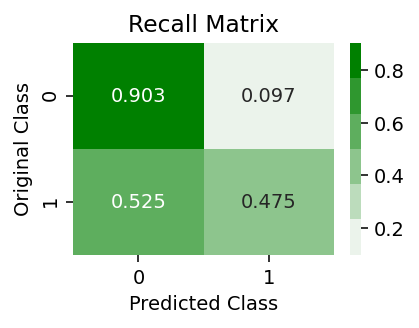

In [105]:
plot_pr_matrix_heatmaps(y_test, y_pred_test)

# Save model

In [106]:
os.makedirs("../data/models/clf/xgboost/", exist_ok=True)

In [108]:
joblib.dump(grid_search_clf.best_estimator_, "../data/models/clf/xgboost/xgb_model.pkl")

['../data/models/clf/xgboost/xgb_model.pkl']